# Challenge Set 13 NLP Unsupervised

Topic: NLP

Date: 02/24/2016

Name: Kenneth Myers

Worked with: NA

In [1]:
import numpy as np
from numpy import zeros
import pandas as pd
import pickle

from random import sample
from random import random
from collections import defaultdict

from sklearn.externals import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity

import nltk
from nltk.tag.perceptron import PerceptronTagger
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer


import re
import os
import codecs
from sklearn import feature_extraction
import matplotlib.pyplot as plt
import mpld3

%matplotlib inline 


/Users/kenn/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/Users/kenn/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/Users/kenn/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/Users/kenn/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'confi

## Challenge 1

Cluster sentences with K-means. If you have your own Fletcher text data, get sentences out and cluster them. If not, cluster the tweets you gathered during the last challenge set. For each cluster, print out the sentences, try to see how close the sentences are. Try different K values and try to find a K value that makes the most sense (the sentences look like they do form a meaningful cluster).

How do you deal with retweets (if you're clustering tweets)?

### Note
I will be working with my own dataset.

In [2]:
with open('tableaucolors.pkl', 'rb') as file:
    tbl_colors = pickle.load(file)

In [3]:
#this is for speeding up pos_tag() since pos_tag() is very slow due to unpickling each time
tagger = PerceptronTagger() 


In [4]:
full_data = pd.read_csv('full_anime_data_set.csv')
full_data.dropna(subset=['synopsis'], inplace=True)
synops = list(full_data['synopsis'])

### Preprocessing

In [5]:
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

In [6]:
stops = set([
    "episode", "dvd", "special", "short", "movie", "included", "recap", "season", 
    "second", "film", "volume", "bundled", "tv", "aired", "version", "ova", 
    "tv", "animation", "animated", "releases", "based", "novel", "ova", "released",
    "manga", "edition", "featuring", "features", "created", "called",
    "main", "lot", "named", "feature", "anime", "adaptation", "releases",
    "series", "information", "original", "characters", "new", "story",
    "ovum", "character", "produced", "final", "meet", "scenes", "various", "plot",
    "video", "meeting", "people", "release", "end", "japanese", "japan", "young",
    "episodes", "include", "specials", "animate", "base", "game", "later", "contain",
    "set", "volumes", "bundle", "air", "different", "limit",
    "a", "about", "above", "across", "after", "afterwards", "again", "against",
    "all", "almost", "alone", "along", "already", "also", "although", "always",
    "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
    "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are",
    "around", "as", "at", "back", "be", "became", "because", "become",
    "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
    "below", "beside", "besides", "between", "beyond", "bill", "both",
    "bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con",
    "could", "couldnt", "cry", "de", "describe", "detail", "do", "done",
    "down", "due", "during", "each", "eg", "eight", "either", "eleven", "else",
    "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
    "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill",
    "find", "fire", "first", "five", "for", "former", "formerly", "forty",
    "found", "four", "from", "front", "full", "further", "get", "give", "go",
    "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter",
    "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his",
    "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed",
    "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter",
    "latterly", "least", "less", "ltd", "made", "many", "may", "me",
    "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly",
    "move", "much", "must", "my", "myself", "name", "namely", "neither",
    "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone",
    "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on",
    "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our",
    "ours", "ourselves", "out", "over", "own", "part", "per", "perhaps",
    "please", "put", "rather", "re", "same", "see", "seem", "seemed",
    "seeming", "seems", "serious", "several", "she", "should", "show", "side",
    "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone",
    "something", "sometime", "sometimes", "somewhere", "still", "such",
    "system", "take", "ten", "than", "that", "the", "their", "them",
    "themselves", "then", "thence", "there", "thereafter", "thereby",
    "therefore", "therein", "thereupon", "these", "they", "thick", "thin",
    "third", "this", "those", "though", "three", "through", "throughout",
    "thru", "thus", "to", "together", "too", "top", "toward", "towards",
    "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us",
    "very", "via", "was", "we", "well", "were", "what", "whatever", "when",
    "whence", "whenever", "where", "whereafter", "whereas", "whereby",
    "wherein", "whereupon", "wherever", "whether", "which", "while", "whither",
    "who", "whoever", "whole", "whom", "whose", "why", "will", "with",
    "within", "without", "would", "yet", "you", "your", "yours", "yourself",
    "yourselves"])

In [7]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text.replace("'", '')) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    #stems = [stemmer.stem(t) for t in filtered_tokens]
    stems = [lemmatizer.lemmatize(t, pos='v') for t in filtered_tokens]
    return stems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text.replace("'", '')) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [8]:
def clean_synops(synopses, nouns_only = False):
    cleaned_synopses = []
    for synopsis in synopses:
        cleaned_tokens = tokenize_and_stem(synopsis)
        cleaned_tokens = [word.lower() for word in cleaned_tokens]
        if nouns_only:
            tags = tagger.tag(cleaned_tokens)
            cleaned_tokens = [t[0] for t in tags if t[1] == "NN"]

        cleaned_synopses.append(" ".join(cleaned_tokens))
        
    return cleaned_synopses
    
        

In [9]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synops:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [10]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 564444 items in vocab_frame


### Bag of words

In [11]:
wordbag_vectorizer = CountVectorizer(analyzer = "word",   \
                                     tokenizer = None,    \
                                     preprocessor = None, \
                                     max_df = 0.2, \
                                     min_df = 0.01, \
                                     stop_words = stops,   \
                                     max_features = 5000)

In [12]:
cleaned_synops = clean_synops(synops)

In [13]:
bag_of_words = wordbag_vectorizer.fit_transform(cleaned_synops)
bag_of_words = bag_of_words.toarray()

In [14]:
vocab_dict = wordbag_vectorizer.vocabulary_

    
terms = []
for k,_ in vocab_dict.items():
    terms.append(k)
    
terms = np.sort(np.array(terms))


In [15]:
num_clusters = 10

km = KMeans(n_clusters=num_clusters)

%time km.fit(bag_of_words)

clusters = km.labels_.tolist()

CPU times: user 12.6 s, sys: 291 ms, total: 12.9 s
Wall time: 9.16 s


In [16]:
full_data['clusters'] = clusters
full_data.set_index('clusters', inplace=True)
full_data.head()
cluster_names = defaultdict(str)

In [17]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    temp_list = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        try:
            temp_list.append(terms[ind])
            print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
        except:
            pass
    #the line below is for creating labels for the graph using the first threw words
    #cluster_names[i] = ', '.join(temp_list[:3])
    
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    try:
        for title in list(full_data.ix[i]['title'].values)[:30]:
            try:
                print(' %s,' % title, end='')
            except:
                pass
    except AttributeError:
        print(full_data.ix[i]['title'])
    
    print() #add whitespace
    print() #add whitespace

Top terms per cluster:

Cluster 0 words: b'schools', b'high', b'girl', b'student', b'day', b'girls',

Cluster 0 titles: School Rumble, Tenshi Kinryouku, Chobits, D.C.: Da Capo, Rozen Maiden, Azumanga Daioh, Cluster Edge, Full Metal Panic? Fumoffu, Soukyuu no Fafner: Dead Aggressor, Shuffle!, Mai-Otome, Aishiteruze Baby★★, Boys Be..., Hana yori Dango, Bakuretsu Tenshi, Sakigake!! Cromartie Koukou, Gate Keepers, Kamikaze Kaitou Jeanne, Kannazuki no Miko, Kanon, Kareshi Kanojo no Jijou, Kono Minikuku mo Utsukushii Sekai, Blood+, Mahou Sensei Negima!, Pita Ten, Shingetsutan Tsukihime, Slam Dunk, Tokyo Underground, Ultra Maniac OVA, Tenkuu no Escaflowne,

Cluster 1 words: b'world', b'life', b'mysterious', b'girl', b'living', b'times',

Cluster 1 titles: One Piece, .hack//Sign, Arc the Lad, Avenger, Chou Henshin Cosprayers, Juuni Kokuki, X, Boukyaku no Senritsu, Scrapped Princess, Strange Dawn, Triangle Heart: Sweet Songs Forever, Tsubasa Chronicle, Yumeria, R.O.D OVA, R.O.D the TV, Cardcapt

## Challenge 2

Draw the inertia curve over different k values. (The sklearn KMeans class has an inertia_ attribute.)

##### K means

In [18]:
inertias = []
cluster_range = list(range(1,18,1))
for cluster_size in cluster_range:
    temp_list = []
    for _ in range(3):
        temp_km = KMeans(n_clusters=cluster_size)
        temp_km.fit(bag_of_words)
        temp_list.append(temp_km.inertia_)
        
    inertias.append(np.mean(temp_list))

/Users/kenn/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/kenn/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


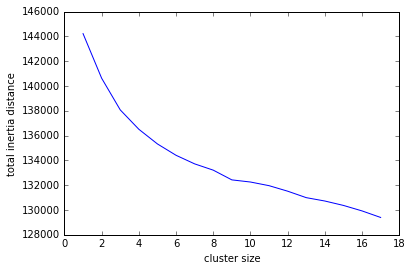

In [19]:
plt.plot(cluster_range, inertias)
plt.ylabel('total inertia distance')
plt.xlabel('cluster size')
plt.show()

## Challenge 3

Let's name the clusters 1

For each cluster, find the sentence closest to the centroid of the cluster.

(You can use [sklearn.metrics.pairwise_distances](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html#sklearn.metrics.pairwise_distances) or [scipy.spatial.distance](http://docs.scipy.org/doc/scipy/reference/spatial.distance.html) [check pdist, cdist, and euclidean distance] to find distances to the centroid). KMeans has a cluster_centers_ attribute.

This sentence (closest to centroid) is now the name of the cluster. For each cluster, print the representative sentence, and print 'N people expressed a similar statement', or something like that relevant to your dataset. (This is very close to what amazon used to do in the reviews section.)

Find the biggest 3 clusters, and print their representative sentences. (This is close to what amazon is doing now in the reviews section, except they choose the sentence from the most helpful review instead of closest to center.)

In [20]:
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    temp_list = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        try:
            temp_list.append(terms[ind])
            print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
        except:
            pass
    
    pw_dists = pairwise_distances(bag_of_words, order_centroids[i].reshape(1,-1))
    min_index = np.argmin(pw_dists)
    
    print('\nMost similar synopsis:')
    print(synops[min_index])
    
    print('\nThe number of series in this cluster is: ', len(full_data.ix[i]), '\n\n')

Cluster 0 words: b'schools', b'high', b'girl', b'student', b'day', b'girls',
Most similar synopsis:
GOSHO collection reveals the origin of the smash hit "Detective Conan." "GO" into his world, and we will "SHO" you SEVEN romantic and exciting stories created by GOSHO AOYAMA. WAIT FOR ME A genius inventor, who is still a high school student, has a girlfriend two years older than him. One day, he invents a time machine and attempts to go two years back into the past, to become the same age as her. However, it is she who ultimately uses the machine to travel through time! TEN PLANETS IN THE NIGHT SKY Meet Baby Conan! Yukiko Kudo is looking for her missing husband. The only clue to find him again is to decipher a mysterious message left for her. Their baby, Shinichi Kudo, one who later becomes the famous high school Detective Conan, will at this age already be offering some important hints for her. THE WANDERING RED BATTERFLY A handsome detective, Yusaku Kitakata, receives phone calls from

This is very interesting and kind of hilarious. The same series is appearing 6 times because it is actually a collection of short stories and the description covers each story (each story being very different). I may need to remove this one in the final analysis

## Challenge 4

Let's name the clusters 2

Calculate the tf-idf of each word in each cluster (think of all sentences of a cluster together as a document). Represent each cluster with the top 1, or top 2 or... to 5 tf-idf words. For each cluster, print the name (keywords) of the cluster, and "N statements" in the cluster (N is the size of the cluster)


In [21]:
full_data = pd.read_csv('full_anime_data_set.csv')
full_data.dropna(subset=['synopsis'], inplace=True)
synops = list(full_data['synopsis'])

In [22]:
cleaned_synops = clean_synops(synops)

In [23]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.2, max_features=200000,
                                   min_df=0.01, stop_words=stops,
                                   use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(cleaned_synops) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

terms = tfidf_vectorizer.get_feature_names()
print(terms)

(8733, 424)
['ability', 'able', 'academy', 'accept', 'accident', 'act', 'action', 'actually', 'adventure', 'age', 'ago', 'alien', 'allow', 'ancient', 'appear', 'arm', 'army', 'arrive', 'art', 'ask', 'attack', 'attempt', 'attend', 'awaken', 'away', 'bad', 'band', 'battle', 'bear', 'beautiful', 'begin', 'believe', 'best', 'better', 'big', 'black', 'blue', 'body', 'book', 'box', 'boy', 'boys', 'break', 'bring', 'brother', 'build', 'captain', 'capture', 'care', 'case', 'cat', 'catch', 'cause', 'center', 'century', 'challenge', 'chance', 'change', 'child', 'childhood', 'childhood friend', 'children', 'choose', 'city', 'class', 'classmates', 'close', 'club', 'combat', 'come', 'comedy', 'company', 'complete', 'continue', 'control', 'country', 'course', 'create', 'creatures', 'crew', 'cute', 'dark', 'daughter', 'day', 'days', 'dead', 'deal', 'death', 'decide', 'deep', 'defeat', 'demon', 'demons', 'desire', 'despite', 'destroy', 'destruction', 'detective', 'determine', 'develop', 'die', 'disapp

In [24]:
dist = 1 - cosine_similarity(tfidf_matrix)

##### K means

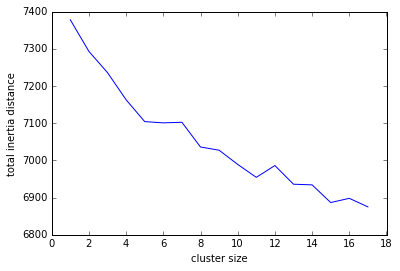

In [25]:
inertias = []
cluster_range = list(range(1,18,1))
for cluster_size in cluster_range:
    temp_list = []
    for _ in range(3):
        temp_km = KMeans(n_clusters=cluster_size)
        temp_km.fit(tfidf_matrix)
        temp_list.append(temp_km.inertia_)
        
    inertias.append(np.mean(temp_list))

plt.plot(cluster_range, inertias)
plt.ylabel('total inertia distance')
plt.xlabel('cluster size')
plt.show()

Meaningless, need to use gap statistics

'''
import scipy
import scipy.cluster.vq
import scipy.spatial.distance
dst = scipy.spatial.distance.euclidean

def min_sparse(X):
    if len(X.data) == 0:
        return 0
    m = X.data.min()
    return m if X.getnnz() == X.size else min(m, 0)

def max_sparse(X):
    if len(X.data) == 0:
        return 0
    m = X.data.max()
    return m if X.getnnz() == X.size else max(m, 0)

def gap(data, refs=None, nrefs=10, ks=range(1,11)):
    """
    Compute the Gap statistic for an nxm dataset in data.
    Either give a precomputed set of reference distributions in refs as an (n,m,k) scipy array,
    or state the number k of reference distributions in nrefs for automatic generation with a
    uniformed distribution within the bounding box of data.
    Give the list of k-values for which you want to compute the statistic in ks.
    """
    shape = data.shape
    if refs==None:
        tops = []
        bots = []
        for i in range(data.shape[1]):
            row = data.getcol(i)
            tops.append(max_sparse(row))
            bots.append(min_sparse(row))

        tops = np.array(tops)
        bots = np.array(bots)
        dists = scipy.matrix(scipy.diag(tops-bots))


        rands = scipy.random.random_sample(size=(shape[0],shape[1],20))
        for i in range(nrefs):
            rands[:,:,i] = rands[:,:,i]*dists+bots
    else:
        rands = refs

    gaps = scipy.zeros((len(ks),))
    for (i,k) in enumerate(ks):
        temp_km = KMeans(n_clusters=k)
        temp_km.fit_transform(data)
        kmc, kml = temp_km.cluster_centers_, temp_km.labels_
        disp = temp_km.inertia_

        refdisps = scipy.zeros((rands.shape[2],))
        for j in range(rands.shape[2]):
            temp_km_2 = KMeans(n_clusters=k)
            temp_km_2.fit_transform(rands[:,:,j])
            refdisps[j] = scipy.log(temp_km_2.inertia_)
        print(k)
        print(scipy.mean(refdisps), scipy.log(disp))
        gaps[i] = scipy.mean(refdisps)-scipy.log(disp)
    return gaps
'''

In [26]:
#gaps = gap(tfidf_matrix, ks=range(1,101,10))

Gap statistics was overly complicated and needs more time to explore

In [27]:
num_clusters = 16

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 9.07 s, sys: 123 ms, total: 9.19 s
Wall time: 10 s


In [28]:
joblib.dump(km,  'doc_cluster.pkl')
km = joblib.load('doc_cluster.pkl')
clusters = list(km.labels_)

In [29]:
clusters[:10]

[10, 10, 0, 0, 6, 7, 0, 0, 0, 10]

In [30]:
full_data['clusters'] = clusters
full_data.set_index('clusters', inplace=True)
full_data.head()
cluster_names = defaultdict(str)

In [31]:
full_data.head()

,title,id,episodes,score,rank,popularity,members,favorites,start_date,end_date,status,type,synopsis
clusters,,,,,,,,,,,,,
10,Cowboy Bebop,1,26,8.83,20,27,266713,17715,1998-04-03,1999-04-24,Finished Airing,TV,"In the year 2071, humanity has colonized sever..."
10,Cowboy Bebop: Tengoku no Tobira,5,1,8.41,145,257,91771,374,2001-09-01,2001-09-01,Finished Airing,Movie,"As the Cowboy Bebop crew travels the stars, th..."
0,Trigun,6,26,8.32,191,72,175287,5575,1998-04-01,1998-09-30,Finished Airing,TV,Vash the Stampede is a wanted man with a habit...
0,Witch Hunter Robin,7,26,7.38,1790,591,50136,409,2002-07-02,2002-12-24,Finished Airing,TV,Witches are individuals with special powers li...
6,Beet the Vandel Buster,8,52,7.05,2889,2337,7620,13,2004-09-30,2005-09-29,Finished Airing,TV,It is the dark century and the people are suff...


In [32]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    temp_list = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        try:
            temp_list.append(terms[ind])
            print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
        except:
            pass
    #the line below is for creating labels for the graph using the first threw words
    cluster_names[i] = ', '.join(temp_list[:3])
    
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    try:
        for title in list(full_data.ix[i]['title'].values)[:30]:
            try:
                print(' %s,' % title, end='')
            except:
                pass
    except AttributeError:
        print(full_data.ix[i]['title'])
        
    print() #add whitespace
    print() #add whitespace

Top terms per cluster:

Cluster 0 words: b'life', b'makes', b'girl', b'living', b'friends', b'love',

Cluster 0 titles: Trigun, Witch Hunter Robin, Hachimitsu to Clover, Hungry Heart: Wild Striker, Initial D Fourth Stage, Ring ni Kakero 1, Sunabouzu, Rurouni Kenshin: Meiji Kenkaku Romantan - Tsuiokuhen, Rurouni Kenshin: Meiji Kenkaku Romantan - Ishinshishi e no Chinkonka, Aa! Megami-sama!, Aa! Megami-sama! (TV), Kidou Tenshi Angelic Layer, Chrno Crusade, D.C.: Da Capo, Rozen Maiden, Rozen Maiden: Träumend, Mobile Suit Gundam: The 08th MS Team - Miller's Report, Mai-HiME, Ayashi no Ceres, Chuuka Ichiban!, El Hazard 2: The Magnificent World, Final Approach, Fullmetal Alchemist, Full Moon wo Sagashite, Fushigi Yuugi: Eikouden, Futakoi Alternative, Saiyuuki Reload Gunlock, Hikaru no Go, Hunter x Hunter OVA, Hunter x Hunter: Greed Island,

Cluster 1 words: b'forest', b'living', b'friends', b'day', b'home', b'adventures',

Cluster 1 titles: Mononoke Hime, Ragnarök the Animation, Damekko Doub

##### Multidimensional scaling/PCA

In [33]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

from sklearn.decomposition import RandomizedPCA

In [34]:
#mds = MDS(n_components=2, dissimilarity="precomputed", n_init=2, max_iter=10, n_jobs=-2, random_state=1)
#pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

r_pca = RandomizedPCA(n_components=2)
pos = r_pca.fit_transform(dist)

xs, ys = pos[:, 0], pos[:, 1]

In [35]:
titles = list(full_data.title)

In [36]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 600);
      this.fig.toolbar.toolbar.attr("y", 0);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [37]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(15,10)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
i=0
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, 
                     label=cluster_names[name], mec='none', 
                     color=tbl_colors[i]
                    )
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    ax.legend(loc='upper left')
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    i+=1

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

## Challenge 5

### Let's name the clusters 3

Same as the previous challenge, but this time, calculate tf-idf only for nouns (NN tag) and build keyword(s) with nouns. (This is close to what amazon switched to last year, before settling into the current design). (They would show five nouns, you would click on one and it would show sentences - linked to the reviews- that were related to that noun.)

In [38]:
full_data = pd.read_csv('full_anime_data_set.csv')
full_data.dropna(subset=['synopsis'], inplace=True)
synops = list(full_data['synopsis'])
%time cleaned_synops = clean_synops(synops, nouns_only=True)

CPU times: user 1min 5s, sys: 1.05 s, total: 1min 6s
Wall time: 1min 8s


In [39]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.15, max_features=200000,
                                   min_df=0.01, stop_words=stops,
                                   use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(cleaned_synops) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

(8733, 192)


In [40]:
terms = tfidf_vectorizer.get_feature_names()
print(terms)

['ability', 'academy', 'accident', 'act', 'action', 'adventure', 'age', 'alien', 'army', 'attack', 'attempt', 'band', 'battle', 'begin', 'body', 'book', 'box', 'boy', 'brother', 'case', 'cat', 'cause', 'center', 'century', 'challenge', 'chance', 'change', 'child', 'childhood', 'childhood friend', 'city', 'class', 'club', 'come', 'comedy', 'company', 'control', 'country', 'course', 'create', 'dark', 'daughter', 'day', 'death', 'decide', 'demon', 'desire', 'destruction', 'die', 'discover', 'dog', 'dragon', 'dream', 'earth', 'empire', 'encounter', 'enemy', 'energy', 'eye', 'face', 'fact', 'fall', 'family', 'fate', 'father', 'feel', 'fight', 'force', 'form', 'friend', 'friendship', 'future', 'galaxy', 'gang', 'ghost', 'girl', 'government', 'group', 'guy', 'hand', 'head', 'heart', 'help', 'hero', 'history', 'home', 'hop', 'house', 'humanity', 'island', 'job', 'join', 'journey', 'kid', 'kind', 'king', 'kingdom', 'land', 'lead', 'leader', 'life', 'light', 'line', 'live', 'look', 'love', 'mach

##### K-means

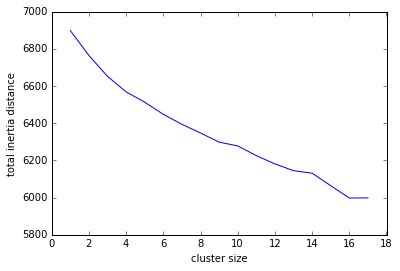

In [41]:
inertias = []
cluster_range = list(range(1,18,1))
for cluster_size in cluster_range:
    temp_list = []
    for _ in range(3):
        temp_km = KMeans(n_clusters=cluster_size)
        temp_km.fit(tfidf_matrix)
        temp_list.append(temp_km.inertia_)
        
    inertias.append(np.mean(temp_list))

plt.plot(cluster_range, inertias)
plt.ylabel('total inertia distance')
plt.xlabel('cluster size')
plt.show()

In [42]:
num_clusters = 13
km = KMeans(n_clusters=num_clusters)
%time km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

CPU times: user 5.78 s, sys: 60.4 ms, total: 5.84 s
Wall time: 5.97 s


In [43]:
full_data['clusters'] = clusters
full_data.set_index('clusters', inplace=True)
full_data.head()
cluster_names = defaultdict(str)

In [44]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    temp_list = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        try:
            temp_list.append(terms[ind])
            print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
        except:
            pass
    #the line below is for creating labels for the graph using the first threw words
    cluster_names[i] = ', '.join(temp_list[:3])
    
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    try:
        for title in list(full_data.ix[i]['title'].values)[:30]:
            try:
                print(' %s,' % title, end='')
            except:
                pass
    except AttributeError:
        print(full_data.ix[i]['title'])
        
    print() #add whitespace
    print() #add whitespace

Top terms per cluster:

Cluster 0 words: b'way', b'girl', b'times', b'life', b'boy', b'day',

Cluster 0 titles: Ai Yori Aoshi, Black Cat, Aishiteruze Baby★★, Hana yori Dango, Chou Henshin Cosprayers, Saiyuuki Reload Gunlock, Kanon, Kareshi Kanojo no Jijou, Loveless, Tenkuu no Escaflowne, Whistle!, Onegai☆Twins, Words Worth, Pia Carrot e Youkoso!! 2 DX, Mezzo Forte, Air Master, Mahou Tsukai ni Taisetsu na Koto, Love♥Love?, 3x3 Eyes, Najica Dengeki Sakusen, Paradise Kiss, Matantei Loki Ragnarok, Memories Off, Tonari no Yamada-kun, Ragnarök the Animation, Spriggan, Stratos 4 Advance, Fullmetal Alchemist: The Conqueror of Shamballa, InuYasha: Guren no Houraijima, One Piece (Movie),

Cluster 1 words: b'life', b'times', b'girl', b'day', b'family', b'man',

Cluster 1 titles: Cowboy Bebop: Tengoku no Tobira, Trigun, Beet the Vandel Buster, Hachimitsu to Clover, Hungry Heart: Wild Striker, Initial D Fourth Stage, Monster, Naruto, Sunabouzu, Yakitate!! Japan, Zipang, Neon Genesis Evangelion, Gho

## Challenge 6

Cluster the same data with [MiniBatchKMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html). MiniBatchKMeans is a fast way to apply K-means to large data without much loss -- The results are very similar. Instead of using EVERY single point to find the new place of the centroid, MiniBatch just randomly samples a small number (like 100) in the cluster to calculate the new center. Since this is usually very close to the actual center, the algorithm gets there much faster. Try it and compare the results. ([Example on two-feature data](http://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html))

In [45]:
full_data = pd.read_csv('full_anime_data_set.csv')
full_data.dropna(subset=['synopsis'], inplace=True)
synops = list(full_data['synopsis'])
%time cleaned_synops = clean_synops(synops, nouns_only=True)

CPU times: user 1min 7s, sys: 1.23 s, total: 1min 9s
Wall time: 1min 13s


In [46]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.15, max_features=200000,
                                   min_df=0.01, stop_words=stops,
                                   use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(cleaned_synops) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

terms = tfidf_vectorizer.get_feature_names()
print(terms)

(8733, 192)
['ability', 'academy', 'accident', 'act', 'action', 'adventure', 'age', 'alien', 'army', 'attack', 'attempt', 'band', 'battle', 'begin', 'body', 'book', 'box', 'boy', 'brother', 'case', 'cat', 'cause', 'center', 'century', 'challenge', 'chance', 'change', 'child', 'childhood', 'childhood friend', 'city', 'class', 'club', 'come', 'comedy', 'company', 'control', 'country', 'course', 'create', 'dark', 'daughter', 'day', 'death', 'decide', 'demon', 'desire', 'destruction', 'die', 'discover', 'dog', 'dragon', 'dream', 'earth', 'empire', 'encounter', 'enemy', 'energy', 'eye', 'face', 'fact', 'fall', 'family', 'fate', 'father', 'feel', 'fight', 'force', 'form', 'friend', 'friendship', 'future', 'galaxy', 'gang', 'ghost', 'girl', 'government', 'group', 'guy', 'hand', 'head', 'heart', 'help', 'hero', 'history', 'home', 'hop', 'house', 'humanity', 'island', 'job', 'join', 'journey', 'kid', 'kind', 'king', 'kingdom', 'land', 'lead', 'leader', 'life', 'light', 'line', 'live', 'look', '

In [47]:
num_clusters = 13
mbk = MiniBatchKMeans(n_clusters=num_clusters)
%time mbk.fit(tfidf_matrix)
clusters = mbk.labels_.tolist()



CPU times: user 197 ms, sys: 10.9 ms, total: 208 ms
Wall time: 225 ms


In [48]:
full_data['clusters'] = clusters
full_data.set_index('clusters', inplace=True)
full_data.head()
cluster_names = defaultdict(str)

In [49]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = mbk.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    temp_list = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        try:
            temp_list.append(terms[ind])
            print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
        except:
            pass
    #the line below is for creating labels for the graph using the first threw words
    cluster_names[i] = ', '.join(temp_list[:3])
    
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    try:
        for title in list(full_data.ix[i]['title'].values)[:30]:
            try:
                print(' %s,' % title, end='')
            except:
                pass
    except AttributeError:
        print(full_data.ix[i]['title'])
        
    print() #add whitespace
    print() #add whitespace

Top terms per cluster:

Cluster 0 words: b'princess', b'dragon', b'treasure', b'sex', b'tale', b'racing',

Cluster 0 titles: Rurouni Kenshin: Meiji Kenkaku Romantan - Tsuiokuhen, Soukyuu no Fafner: Dead Aggressor, GetBackers, Re: Cutie Honey, Love Hina Again, Mezzo DSA, Jigoku Shoujo, Love♥Love?, Chiisana Obake Acchi, Kocchi, Socchi, Ace wo Nerae!: Final Stage, Petshop of Horrors, Puchi Puri Yuushi, Ginyuu Mokushiroku Meine Liebe, Ojamajo Doremi Dokkaan!, Gallery Fake, Fake, Escaflowne, Seikai no Senki Special, Stratos 4 OVA, Final Fantasy, Naruto Movie 1: Dai Katsugeki!! Yuki Hime Shinobu Houjou Dattebayo!, Weiß Kreuz Glühen, .hack//Gift, One Piece: Omatsuri Danshaku to Himitsu no Shima, Ghost in the Shell 2: Innocence, Dragon Ball Movie 1: Shen Long no Densetsu, Tekken, Steel Angel Kurumi Encore, Legend of Duo, Sakura Taisen: Katsudou Shashin,

Cluster 1 words: b'world', b'life', b'times', b'day', b'family', b'man',

Cluster 1 titles: Trigun, Beet the Vandel Buster, Monster, Naruto, 

## Challenge 7

Switch the init parameter to "random" (instead of the default kmeans++) and plot the inertia curve for each of the n_init values for K-Means: 1, 2, 3, 10 (n_init is the number of different runs to try with different random initializations).

In [62]:
class get_clusters(object):
    def __init__(self):
        #reset the data and clean the synopses
        self.reset_full_data()

        #get tf-idf matrix of terms
        self.tfidf_vectorizer = TfidfVectorizer(max_df=0.15, max_features=200000,
                                       min_df=0.01, stop_words=stops,
                                       use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

        self.tfidf_matrix = tfidf_vectorizer.fit_transform(cleaned_synops) #fit the vectorizer to synopses

        print("tfidf shape: ", tfidf_matrix.shape)
        self.terms = tfidf_vectorizer.get_feature_names()
        print("terms list:\n", terms)
    
    def reset_full_data(self):
        self.full_data = pd.read_csv('full_anime_data_set.csv')
        self.full_data.dropna(subset=['synopsis'], inplace=True)
        self.synops = list(self.full_data['synopsis'])
        self.cleaned_synops = clean_synops(synops, nouns_only=True)
    
    def get_top_terms_and_series(self, cluster_model):
        #declare and fit cluster model
        cluster_model = cluster_model
        cluster_model.fit(self.tfidf_matrix)
        clusters = cluster_model.labels_.tolist()

        #Set the index of data to cluster numbers
        data = self.full_data
        data['clusters'] = clusters
        data.set_index('clusters', inplace=True)
        
        #Prints out the top 6 cluster terms and series from cluster
        cluster_names = defaultdict(str)
        print("Top terms per cluster:")
        print()
        #sort cluster centers by proximity to centroid
        order_centroids = cluster_model.cluster_centers_.argsort()[:, ::-1] 

        for i in range(num_clusters):
            print("Cluster %d words:" % i, end='')

            temp_list = []
            for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
                try:
                    temp_list.append(terms[ind])
                    print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
                except:
                    pass
            #the line below is for creating labels for the graph using the first threw words
            cluster_names[i] = ', '.join(temp_list[:3])

            print() #add whitespace
            print() #add whitespace

            print("Cluster %d titles:" % i, end='')
            try:
                for title in list(full_data.ix[i]['title'].values)[:30]:
                    try:
                        print(' %s,' % title, end='')
                    except:
                        pass
            except AttributeError:
                print(full_data.ix[i]['title'])

            print('\n\n') #add whitespace
            

In [61]:
challenge_7 = get_clusters()

tfidf shape:  (8733, 192)
terms list:
 ['ability', 'academy', 'accident', 'act', 'action', 'adventure', 'age', 'alien', 'army', 'attack', 'attempt', 'band', 'battle', 'begin', 'body', 'book', 'box', 'boy', 'brother', 'case', 'cat', 'cause', 'center', 'century', 'challenge', 'chance', 'change', 'child', 'childhood', 'childhood friend', 'city', 'class', 'club', 'come', 'comedy', 'company', 'control', 'country', 'course', 'create', 'dark', 'daughter', 'day', 'death', 'decide', 'demon', 'desire', 'destruction', 'die', 'discover', 'dog', 'dragon', 'dream', 'earth', 'empire', 'encounter', 'enemy', 'energy', 'eye', 'face', 'fact', 'fall', 'family', 'fate', 'father', 'feel', 'fight', 'force', 'form', 'friend', 'friendship', 'future', 'galaxy', 'gang', 'ghost', 'girl', 'government', 'group', 'guy', 'hand', 'head', 'heart', 'help', 'hero', 'history', 'home', 'hop', 'house', 'humanity', 'island', 'job', 'join', 'journey', 'kid', 'kind', 'king', 'kingdom', 'land', 'lead', 'leader', 'life', 'light'

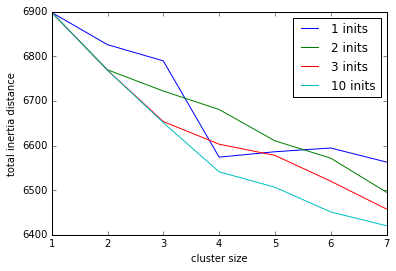

In [65]:
for i in [1,2,3,10]:
    inertias = []
    cluster_range = list(range(1,8,1))
    for cluster_size in cluster_range:
        temp_list = []
        for _ in range(3):
            temp_km = KMeans(n_clusters=cluster_size, n_init=i)
            temp_km.fit(challenge_7.tfidf_matrix)
            temp_list.append(temp_km.inertia_)

        inertias.append(np.mean(temp_list))

    label= str(i) + ' inits'
    plt.plot(cluster_range, inertias, label=label)
    plt.legend(loc='best')
    plt.ylabel('total inertia distance')
    plt.xlabel('cluster size')

plt.show()


## Challenge 8

Download [this dataset on the purchase stats](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers) from clients of a wholesale distributor. Cluster the clients based on their annual spending features (fresh, milk, grocery, frozen, detergents_paper, delicatessen). Remember to scale the features before clustering. After finding a reasonable amount of clusters, for EACH cluster, plot the histogram for every single feature: FRESH, MILK, GROCERY, FROZEN, DETERGENTS_PAPER, DELICATESSEN, CHANNEL, REGION. Is there a natural way to characterize each cluster? How would you describe each cluster to the wholesale distributor if you were working for them?

#### Note:
Link was broken when I tried it so I skipped this.

## Clustering Extensions (Optional)

Use the same code for your previous clustering challenges.

Repeat each challenge (except the inertia curves, since only the KMeans implementation gives a quick way of calculating that.) However, this time, try (both) Agglomerative Clustering and DBSCAN instead of KMeans.

For text clustering, use cosine distance.